# Задача 10. Рекомендательный сервис для определения оптимальных мест размещения постаматов в рамках проекта "Московский постамат"

**Задача:** Разработать сервис для предоставления рекомендаций по оптимальному размещению постаматов возле городских киосков или на городской территории с точки зрения потенциальной востребованности постамата у жителей города (далее – сервис). 


Сервис позволит повысить востребованность устанавливаемых постаматов, а также обеспечить доступность удобного и безопасного способа доставки для наибольшего количества москвичей.

## 1. Предварительная обработка данных

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns

import re

from tqdm import tqdm

sns.set()

In [539]:
! ls ./data/geojson_source

entrances_and_exits_of_moscow_central_diameter_stations.csv
houses_of_culture_and_clubs.csv
libraries.csv
multifunctional_centers.csv
non_stationary_trade_objects.csv
printed_products.csv
sport_objects.csv


In [5]:
data_path = './data/geojson_source/'
datasets = ['houses_of_culture_and_clubs', 'houses_reester',
            'libraries', 'multifunctional_centers', 'non_stationary_trade_objects',
            'printed_products', 'sport_objects',
            'entrances_and_exits_of_moscow_central_diameter_stations']

In [6]:
houses_of_culture_and_clubs = pd.read_csv(f'{data_path}houses_of_culture_and_clubs.csv')
libraries = pd.read_csv(f'{data_path}libraries.csv')
multifunctional_centers = pd.read_csv(f'{data_path}multifunctional_centers.csv')
non_stationary_trade_objects = pd.read_csv(f'{data_path}non_stationary_trade_objects.csv')
printed_products = pd.read_csv(f'{data_path}printed_products.csv')
sport_objects = pd.read_csv(f'{data_path}sport_objects.csv')
entrances_and_exits_of_mcd = pd.read_csv(f'{data_path}entrances_and_exits_of_moscow_central_diameter_stations.csv')

## 1.1 Обработка типов данных и пропусков

### 1.1.1 Обработка данных в формате geojson

In [7]:
import json

In [97]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

def remove_extra_geometry_coords(df, pattern="geometry_coordinates_*."):
    cols = df.columns
    pattern = re.compile(pattern)
    new_cols = [x for x in cols if not pattern.match(x)]
    if ((len(df.columns) - len(new_cols)) > 2) or ('geometry_coordinates_0_0' in cols):
        new_cols += ['geometry_coordinates_0_0', 'geometry_coordinates_0_1']
    else:
        new_cols += ['geometry_coordinates_0', 'geometry_coordinates_1']
    for col_name in ['properties_RowId', 'properties_VersionNumber', 'geometry_type', 'type']:
        new_cols.remove(col_name)
    new_df = df[new_cols]
    new_df.columns = list(new_df.columns[:-2]) + ['lon', 'lat']
    return new_df

def make_final_df(df):
    final_df = pd.DataFrame()
    for item in tqdm(df['features']):
        final_df = final_df.append(flatten_json(json.loads(item.replace('\"', '\\"').replace('\'', '\"')\
                                                           .replace("None", "null"))), ignore_index=True)
    return remove_extra_geometry_coords(final_df)

In [102]:
houses_of_culture_and_clubs_df = make_final_df(houses_of_culture_and_clubs)
libraries_df = make_final_df(libraries)
entrances_and_exits_of_mcd_df = make_final_df(entrances_and_exits_of_mcd)
multifunctional_centers_df = make_final_df(multifunctional_centers)
printed_products_df = make_final_df(printed_products)
non_stationary_trade_objects_df = make_final_df(non_stationary_trade_objects)
sport_objects = make_final_df(sport_objects)

100%|██████████| 346/346 [16:15<00:00,  2.82s/it]


*Очистим данные от лишних пустых колонок.*

In [543]:
new_cols = []
for col in sport_objects.columns:
    empty_share = (sport_objects[col].isna() * 1).sum() / len(sport_objects)
    if empty_share < 0.5:
        new_cols.append(col)

### 1.1.2 Обработка данных в формате raw csv

In [169]:
# houses_of_culture_and_clubs = pd.read_csv(f'{data_path}houses_of_culture_and_clubs.csv')
# libraries = pd.read_csv(f'{data_path}libraries.csv')
# multifunctional_centers = pd.read_csv(f'{data_path}multifunctional_centers.csv')
# non_stationary_trade_objects = pd.read_csv(f'{data_path}non_stationary_trade_objects.csv')
# printed_products = pd.read_csv(f'{data_path}printed_products.csv')
# sport_objects = pd.read_csv(f'{data_path}sport_objects.csv')
# entrances_and_exits_of_mcd = pd.read_csv(f'{data_path}entrances_and_exits_of_moscow_central_diameter_stations.csv')

In [102]:
# houses_reester['address'].to_csv('addresses.csv')
# houses_reester['address'][houses_reester['address'].apply(lambda x: x.find('Липецкая') != -1)]

In [173]:
! ls ./data/raw

address_reester.xlsx                 non_stationary_trade_objects_raw.csv
houses_of_culture_and_clubs_raw.csv  printed_products_raw.csv
libraries_raw.csv                    sport_objects_raw.csv
mfc_raw.csv                          stations


In [545]:
import warnings
warnings.filterwarnings("ignore")

In [558]:
houses_of_culture_and_clubs_raw = pd.read_csv('./data/raw/houses_of_culture_and_clubs_raw.csv')
address_reester_raw = pd.read_csv('./data/raw/address_reester_raw.csv')
libraries_raw = pd.read_csv('./data/raw/libraries_raw.csv')
multifunctional_centers_raw = pd.read_csv('./data/raw/mfc_raw.csv')
non_stationary_trade_objects_raw = pd.read_csv('./data/raw/non_stationary_trade_objects_raw.csv')
printed_products_raw = pd.read_csv('./data/raw/printed_products_raw.csv')
sport_objects_raw = pd.read_csv('./data/raw/sport_objects_raw.csv')

In [559]:
sport_objects_raw = sport_objects_raw.iloc[1:, :].reset_index().iloc[:, 1:]
address_reester_raw = address_reester_raw.iloc[1:, :].reset_index().iloc[:, 1:]

В этом формате большое количество столбцов заполнено null-aми.

In [548]:
libraries_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Category                        270 non-null    object 
 1   CommonName                      270 non-null    object 
 2   FullName                        270 non-null    object 
 3   ShortName                       270 non-null    object 
 4   OrgInfo                         270 non-null    object 
 5   ObjectAddress                   270 non-null    object 
 6   ChiefOrg                        267 non-null    object 
 7   ChiefName                       270 non-null    object 
 8   ChiefPosition                   270 non-null    object 
 9   PublicPhone                     270 non-null    object 
 10  Fax                             118 non-null    object 
 11  Email                           270 non-null    object 
 12  WorkingHours                    270 

In [549]:
! ls ./data/raw/stations

mcd_station.csv            metro_station.csv
metro_passenger_flow.csv   metro_station_entrance.csv


In [707]:
mcd_station_raw = pd.read_csv('./data/raw/stations/mcd_station.csv')
metro_station_raw = pd.read_csv('./data/raw/stations/metro_station.csv')
metro_station_entrance_raw = pd.read_csv('./data/raw/stations/metro_station_entrance.csv')
metro_passenger_flow_raw = pd.read_csv('./data/raw/stations/metro_passenger_flow.csv')

In [551]:
def remove_extra_en_fields(df, pattern=".*_en", extra=True):
    cols = df.columns
    pattern = re.compile(pattern)
    new_cols = [x for x in cols if not pattern.match(x)]
    if extra:
        for col_name in ['global_id', 'geodata_center', 'geoarea']:
            new_cols.remove(col_name)
    new_df = df[new_cols]
    return new_df

In [708]:
mcd_station_raw = remove_extra_en_fields(mcd_station_raw)
metro_station_raw = remove_extra_en_fields(metro_station_raw)
metro_station_entrance_raw = remove_extra_en_fields(metro_station_entrance_raw)
metro_passenger_flow_raw = remove_extra_en_fields(metro_passenger_flow_raw, extra=False)

In [560]:
houses_of_culture_and_clubs_raw = remove_extra_en_fields(houses_of_culture_and_clubs_raw)
address_reester_raw = remove_extra_en_fields(address_reester_raw)
libraries_raw = remove_extra_en_fields(libraries_raw)
multifunctional_centers_raw = remove_extra_en_fields(multifunctional_centers_raw)
non_stationary_trade_objects_raw = remove_extra_en_fields(non_stationary_trade_objects_raw)
printed_products_raw = remove_extra_en_fields(printed_products_raw)
sport_objects_raw = remove_extra_en_fields(sport_objects_raw)

In [561]:
libraries_raw.head(1)

,Category,CommonName,FullName,ShortName,OrgInfo,ObjectAddress,ChiefOrg,ChiefName,ChiefPosition,PublicPhone,Fax,Email,WorkingHours,ClarificationOfWorkingHours,WebSite,NumOfSeats,NumOfReaders,NumOfVisitors
0,Библиотека,Библиотека №140,Государственное бюджетное учреждение культуры ...,"ГБУК г. Москвы «ОКЦ ЮАО», Библиотека №140",ChiefPhone:(495) 682-44-22\n FullName:Государс...,AdmArea:Южный административный округ\n Distric...,Государственное бюджетное учреждение культуры ...,Алмазова-Долженко Людмила Константиновна,заведующий,PublicPhone:(495) 682-42-22,NaN,Email:140libzav@cbsuao.ru,DayWeek:понедельник\n WorkHours:выходной\n \n ...,Последняя пятница месяца - санитарный день.,bibliouao.ru,30.0,6103.0,45840.0


### 1.1.3 Обработка реестра домов

In [576]:
house_reester = pd.read_csv('./data/houses_reester.csv')

In [577]:
house_reester.head()

,coordinates,address,"square, m2",year,floor_cnt,entrance_cnt,apartment_cnt
0,"55.834472,37.65805","пр-кт. Мира, д. 188 Б, к. 1, Москва",54804.10,2014,58,1,370
1,"55.835483,37.658338","пр-кт. Мира, д. 188Б, к. 3, Москва",53253.20,2015,58,1,356
2,"55.7984977,37.5207235","пер. Чапаевский, д. 3, Москва",256740.60,2006,57,14,992
3,"55.723592,37.527256","ул. Мосфильмовская, д. 8, Москва",137500.80,2011,53,2,564
4,"55.71518,37.506612","ул. Мосфильмовская, д. 70, Москва",341272.69,2006,50,7,1046


In [605]:
house_reester = house_reester[house_reester.coordinates != 'none']
house_reester['lat'] = house_reester['coordinates'].apply(lambda x: x.split(',')[0])
house_reester['lon'] = house_reester['coordinates'].apply(lambda x: x.split(',')[1])

In [607]:
house_reester.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33394 entries, 0 to 33397
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   coordinates    33394 non-null  object
 1   address        33394 non-null  object
 2   square, m2     33394 non-null  object
 3   year           33394 non-null  object
 4   floor_cnt      33394 non-null  object
 5   entrance_cnt   4072 non-null   object
 6   apartment_cnt  4062 non-null   object
 7   lat            33394 non-null  object
 8   lon            33394 non-null  object
dtypes: object(9)
memory usage: 2.5+ MB


Видим, что данных по количеству подъездов и апартаментов достаточно мало – далее обучим модель предсказывать эти значения, чтобы оценивать плотность населения в разных локациях города.

### 1.1.4 Обработка данных по пунктам выдачи заказов

In [610]:
! ls ./data/pvz

cdek.csv        ozon.csv        wildberries.csv yandex.csv


In [620]:
cdek = pd.read_csv('./data/pvz/cdek.csv')
ozon = pd.read_csv('./data/pvz/ozon.csv')
wildberries = pd.read_csv('./data/pvz/wildberries.csv')
yandex = pd.read_csv('./data/pvz/yandex.csv')

In [621]:
def get_lat_lon_by_coodrinates(df, sep=','):
    df = df[df.coordinates != 'none']
    df['lat'] = df['coordinates'].apply(lambda x: x.split(',')[0])
    df['lon'] = df['coordinates'].apply(lambda x: x.split(',')[1])
    return df

In [622]:
cdek = get_lat_lon_by_coodrinates(cdek)
ozon = get_lat_lon_by_coodrinates(ozon)
wildberries = get_lat_lon_by_coodrinates(wildberries)
yandex = get_lat_lon_by_coodrinates(yandex)

Далее в моделях будем учитывать количество пунктов выдачи в окрестности.

### 1.1.5 Обработка станций метро, МЦК, МЦД

In [709]:
mcd_station_raw['StationName'] = mcd_station_raw['Diameter'].apply(lambda x: x.split('\n')[0][x.find(':')+1:])

In [710]:
mcd_station_raw = mcd_station_raw[~mcd_station_raw.AdmArea.isna()]

In [711]:
mcd_station_raw = mcd_station_raw.groupby(by=['StationName', 'AdmArea', 'District']).agg({
    'Latitude_WGS84': 'max', 'Longitude_WGS84': 'max'
}).reset_index()

In [713]:
mcd_station_raw.columns = ['StationName', 'AdmArea', 'District', 'lat', 'lon']
mcd_station_raw.head()

,StationName,AdmArea,District,lat,lon
0,Беговая,Центральный административный округ,Пресненский район,55.773365,37.549662
1,Белорусская,Северный административный округ,район Беговой,55.777623,37.581279
2,Белорусская,Центральный административный округ,Тверской район,55.777095,37.582197
3,Бескудниково,Северо-Восточный административный округ,Алтуфьевский район,55.882877,37.569944
4,Бутово,Юго-Западный административный округ,район Южное Бутово,55.542269,37.571564


In [714]:
metro_station_raw = metro_station_raw[['NameOfStation', 'AdmArea', 'Latitude_WGS84', 'Longitude_WGS84', 'District']]
metro_station_raw.columns = ['StationName', 'AdmArea', 'lat', 'lon', 'District']

In [717]:
metro_station_raw = metro_station_raw.groupby(by=['StationName', 'AdmArea', 'District']).agg({
    'lat': 'max', 'lon': 'max'
}).reset_index()

Дублирование станций необходимо для того, чтобы можно было учесть одну при отфильтровывании в каждом из районов, которые может выбрать пользователь. При подсчете количества станций в окрестности каждая станция будет учитываться один раз.

## 1.2 Сбор информации по каждой сущности

Соберем для каждого типа объекта данные в единый датафрейм.

### 1.2.1 Нежилые объекты

In [562]:
culture_house = pd.merge(houses_of_culture_and_clubs_df, houses_of_culture_and_clubs_raw,
                           left_index=True, right_index=True)
library = pd.merge(libraries_df, libraries_raw, left_index=True, right_index=True)
multifunctional = pd.merge(multifunctional_centers_df, multifunctional_centers_raw,
                           left_index=True, right_index=True)
sports = pd.merge(sport_objects, sport_objects_raw, left_index=True, right_index=True)

In [567]:
non_stationary_trade_objects = pd.merge(non_stationary_trade_objects_df,
                                        non_stationary_trade_objects_raw,
                                        left_index=True, right_index=True)
printed_products = pd.merge(printed_products_df, printed_products_raw,
                            left_index=True, right_index=True)
kiosk = printed_products.append(non_stationary_trade_objects)

In [868]:
metro_station_raw['decription'] = 'Станция метро/МЦК'
mcd_station_raw['decription'] = 'Станция МЦД'
underground = metro_station_raw.append(mcd_station_raw)

In [719]:
underground.head()

,StationName,AdmArea,District,lat,lon
0,Авиамоторная,Восточный административный округ,район Соколиная Гора,55.753246,37.719478
1,Авиамоторная,Юго-Восточный административный округ,район Лефортово,55.752312,37.717822
2,Автозаводская,Южный административный округ,Даниловский район,55.708597,37.662899
3,Академическая,Юго-Западный административный округ,Академический район,55.688773,37.574804
4,Александровский сад,Центральный административный округ,Тверской район,55.752239,37.612392


Все полученные датасеты представляют собой потенциальные места для того, чтобы поставить в них постаматы.

Приведем их к общему виду для дальнейшей генерации общих признаков для модели.

In [789]:
def make_common_format(df, object_type):
    df_ = pd.DataFrame()
    df_['title'] = df.ShortName
    df_['description'] = df.Category
    df_['type'] = object_type
    df_['lat'] = df.lat
    df_['lon'] = df.lon
    df_['area'] = df['ObjectAddress'].apply(lambda x: x.split('\n ')[0])\
                                .apply(lambda x: x[x.find(':')+1:])
    df_['district'] = df['ObjectAddress'].apply(lambda x: x.split('\n ')[1])\
                                .apply(lambda x: x[x.find(':')+1:])
    df_['address'] = df['ObjectAddress'].apply(lambda x: x.split('\n ')[3])\
                                .apply(lambda x: x[x.find(':')+1:])
    df_['district'] = df_['district'].apply(lambda x: x.replace('район', '').strip())
    for segment in ['Южное', 'Северное', 'Западное', 'Восточное', 'Центральное']:
        df_['district'] = df_['district']\
            .apply(lambda x: (x.replace(segment, '').strip() + ' ' + segment).strip() if x.find(segment) != -1 else x)
    return df_

In [784]:
library_ = make_common_format(library, 'library')
culture_house_ = make_common_format(culture_house, 'culture_house')

In [796]:
multifunctional_ = multifunctional[['ShortName', 'lat', 'lon', 'properties_Attributes_AdmArea',
                                   'properties_Attributes_District', 'properties_Attributes_Address']]
multifunctional_.columns = ['title', 'lat', 'lon', 'area', 'district', 'address']
multifunctional_['description'] = 'Многофункциональный центр предоставления государственных и муниципальных услуг'
multifunctional_['type'] = 'multifunctional'
multifunctional_['district'] = multifunctional_['district'].apply(lambda x: x.replace('район', '').strip())
for segment in ['Южное', 'Северное', 'Западное', 'Восточное', 'Центральное']:
    multifunctional_['district'] = multifunctional_['district']\
        .apply(lambda x: (x.replace(segment, '').strip() + ' ' + segment).strip() if x.find(segment) != -1 else x)

In [823]:
kiosk_ = kiosk[['lat', 'lon', 'properties_Attributes_AdmArea',
                                   'properties_Attributes_District', 'properties_Attributes_Address']]
kiosk_.columns = ['lat', 'lon', 'area', 'district', 'address']
kiosk_['title'] = kiosk.properties_Attributes_Name
kiosk_['description'] = kiosk.properties_Attributes_Specialization.fillna('')
kiosk_['type'] = 'kiosk'
kiosk_['district'] = kiosk_['district'].apply(lambda x: x.replace('район', '').strip())
for segment in ['Южное', 'Северное', 'Западное', 'Восточное', 'Центральное']:
    kiosk_['district'] = kiosk_['district']\
        .apply(lambda x: (x.replace(segment, '').strip() + ' ' + segment).strip() if x.find(segment) != -1 else x)

In [859]:
stub = sports[~sports['ObjectAddress'].isna()]
sports_ = stub[['lat', 'lon']]
sports_['title'] = stub.properties_Attributes_FullName
sports_['description'] = stub.Category.fillna('')
sports_['type'] = 'sports'
sports_['area'] = stub['ObjectAddress'].apply(lambda x: x.split('\n ')[0])\
                            .apply(lambda x: x[x.find(':')+1:])
sports_['district'] = stub['ObjectAddress'].apply(lambda x: x.split('\n ')[1])\
                            .apply(lambda x: x[x.find(':')+1:])
sports_['address'] = stub['ObjectAddress'].apply(lambda x: x.split('\n ')[3])\
                            .apply(lambda x: x[x.find(':')+1:])
sports_['district'] = sports_['district'].apply(lambda x: x.replace('район', '').strip())
for segment in ['Южное', 'Северное', 'Западное', 'Восточное', 'Центральное']:
    sports_['district'] = sports_['district']\
        .apply(lambda x: (x.replace(segment, '').strip() + ' ' + segment).strip() if x.find(segment) != -1 else x)


In [870]:
underground.columns = ['title', 'area', 'district', 'lat', 'lon', 'description']
underground['title'] = 'Станция ' + underground['title']
underground['district'] = underground['district'].apply(lambda x: x.replace('район', '').strip())
underground['type'] = 'underground'
for segment in ['Южное', 'Северное', 'Западное', 'Восточное', 'Центральное']:
    underground['district'] = underground['district']\
        .apply(lambda x: (x.replace(segment, '').strip() + ' ' + segment).strip() if x.find(segment) != -1 else x)

Соберем отформатированные объекты вместе:

In [885]:
candidates = library_.append(culture_house_).append(multifunctional_)\
                .append(kiosk_).append(sports_).append(underground).fillna('')

In [887]:
candidates.head()

,title,description,type,lat,lon,area,district,address
0,"ГБУК г. Москвы «ОКЦ ЮАО», Библиотека №140",Библиотека,library,55.583967,37.685992,Южный административный округ,Бирюлёво Восточное,"Российская Федерация, город Москва, внутригоро..."
1,"ГБУК г. Москвы «ОКЦ ЮАО», Библиотека №166 им. ...",Библиотека,library,55.708619,37.586619,Южный административный округ,Донской,"Российская Федерация, город Москва, внутригоро..."
2,"ГБУК г. Москвы «ОКЦ ЮЗАО», Библиотека №169 «Пр...",Библиотека,library,55.646156,37.477928,Юго-Западный административный округ,Тёплый Стан,"город Москва, Ленинский проспект, дом 127"
3,"ГБУК г. Москвы «ОКЦ ТиНАО», Библиотека №266 им...",Библиотека,library,55.659028,37.330996,Новомосковский административный округ,поселение Внуковское,"город Москва, поселение Внуковское, посёлок ДС..."
4,"ГБУК г. Москвы «ОКЦ ЮВАО», Библиотека №115",Библиотека,library,55.708541,37.782957,Юго-Восточный административный округ,Кузьминки,"Российская Федерация, город Москва, внутригоро..."


### 1.2.2 Жилые дома

#### 1.2.2.1 Расчет административных округов и районов

В датасете домов не хватает информации об округах и районах – получим их методом ближайших соседей, сравнивая с уже известными объектами, полученными выше.

In [911]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

In [928]:
house_reester = house_reester[house_reester['lat'] != "None"]
house_reester = house_reester[house_reester['lon'] != "None"]

In [934]:
clf_area = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree')\
            .fit(candidates[['lat', 'lon']], candidates['area'])

In [935]:
house_reester['area'] = clf_area.predict(house_reester[['lat', 'lon']])

In [940]:
clf_district = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')\
            .fit(candidates[['lat', 'lon']], candidates['district'])

In [941]:
house_reester['district'] = clf_district.predict(house_reester[['lat', 'lon']])

In [943]:
house_reester.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33393 entries, 0 to 33397
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   coordinates    33393 non-null  object
 1   address        33393 non-null  object
 2   square, m2     33393 non-null  object
 3   year           33393 non-null  object
 4   floor_cnt      33393 non-null  object
 5   entrance_cnt   4071 non-null   object
 6   apartment_cnt  4061 non-null   object
 7   lat            33393 non-null  object
 8   lon            33393 non-null  object
 9   area           33393 non-null  object
 10  district       33393 non-null  object
dtypes: object(11)
memory usage: 3.1+ MB


#### 1.2.2.2. Расчет количества помещений/квартир

Для расчета покрытия необходимо понимать, как спрос распределен по географии. Эту информацию помогло бы получить приближенное вычисление количества жителей в каждом доме.

In [1027]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [1007]:
data = house_reester.copy()

In [1021]:
data = data[~data['apartment_cnt'].isna()][data['square, m2'] != 'Не заполнено']\
    [data['square, m2'] != 'Feb-40'][data['apartment_cnt'] != 'не указано']\
    [data['year'] != 'Не заполнено'][data['floor_cnt'] != 'Не заполнено'][data['apartment_cnt'] != 'Не указано']
# data.drop(['address', 'coordinates', 'entrance_cnt', 'area', 'district'], axis=1, inplace=True)

**Обучим линейную регрессию**

In [1023]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('apartment_cnt', axis=1), data['apartment_cnt'], test_size=0.33, random_state=42)

In [1024]:
reg = LinearRegression().fit(X_train, y_train)

In [1025]:
reg.score(X_train, y_train)

0.6018154079124773

In [1026]:
y_pred = reg.predict(X_test)

In [1028]:
mean_squared_error(y_pred, y_test)

6818.1417790003015

In [1032]:
reg2 = LinearRegression().fit(X_train.drop(['lat', 'lon'], axis=1), y_train)
reg2.score(X_train.drop(['lat', 'lon'], axis=1), y_train)
y_pred2 = reg2.predict(X_test.drop(['lat', 'lon'], axis=1))

In [1033]:
mean_squared_error(y_pred2, y_test)

6899.98269965296

Модель с большим количеством фичей оказалась получше. Посмотрим на распределение предсказаний:

In [1035]:
import matplotlib.pyplot as plt

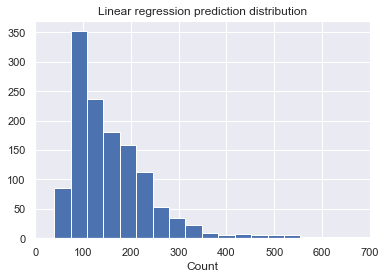

In [1045]:
plt.hist(y_pred, bins=34)
plt.xlabel('Apartments prediction')
plt.xlabel('Count')
plt.xlim(0, 700)
plt.title('Linear regression prediction distribution')
plt.show()

**Обучим градиентный бустинг**

In [1064]:
data = house_reester.copy()

In [1065]:
data = data[~data['apartment_cnt'].isna()][data['square, m2'] != 'Не заполнено']\
    [data['square, m2'] != 'Feb-40'][data['apartment_cnt'] != 'не указано']\
    [data['year'] != 'Не заполнено'][data['floor_cnt'] != 'Не заполнено'][data['apartment_cnt'] != 'Не указано']

In [1066]:
data.drop(['coordinates', 'address', 'entrance_cnt', 'square, m2', 'area', 'district'], axis=1, inplace=True)

In [1067]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('apartment_cnt', axis=1), data['apartment_cnt'], random_state=0)

In [1068]:
rbg = GradientBoostingRegressor(random_state=42)
rbg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [1069]:
y_pred3 = rbg.predict(X_test)

In [1070]:
mean_squared_error(y_pred3, y_test)

10144.585422959235

Бустинг оказался ненужным усложнением – самая просто первая модель показала качество лучше, восспользуемся ей.

In [1101]:
data = house_reester.copy()

In [1102]:
house_reester_ = data[~data['apartment_cnt'].isna()][data['square, m2'] != 'Не заполнено']\
    [data['square, m2'] != 'Feb-40'][data['apartment_cnt'] != 'не указано']\
    [data['year'] != 'Не заполнено'][data['floor_cnt'] != 'Не заполнено']\
    [data['apartment_cnt'] != 'Не указано'].copy()

In [1104]:
d = data[data['apartment_cnt'].isna()][data['square, m2'] != 'Не заполнено']\
    [data['square, m2'] != 'Feb-40'][data['square, m2'] != 'Apr-64'][data['year'] != 'Не заполнено']\
    [data['floor_cnt'] != 'Не заполнено'].copy()

In [1105]:
data.drop(['address', 'coordinates', 'entrance_cnt', 'area', 'district'], axis=1, inplace=True)

In [1119]:
d['apartment_cnt'] = reg.predict(d.drop(
    ['address', 'coordinates', 'entrance_cnt', 'area', 'district', 'apartment_cnt'], axis=1)).astype(int)

In [1124]:
sum(d['apartment_cnt'] <= 0)

0

In [1125]:
house_reester_ = house_reester_.append(d)

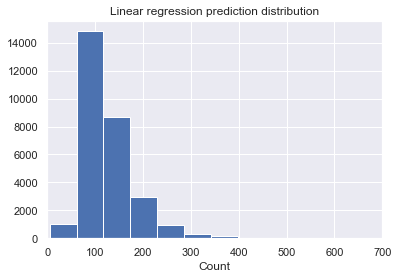

In [1121]:
plt.hist(d['apartment_cnt'], bins=34)
plt.xlabel('Apartments prediction')
plt.xlabel('Count')
plt.xlim(0, 700)
plt.title('Linear regression prediction distribution')
plt.show()

Первым приближением количества жильцов будет по три человека на квартиру.

In [1346]:
house_reester_['apartment_cnt'] = house_reester_['apartment_cnt'].astype(float)

In [1348]:
house_reester_['apartment_cnt'].max()

2570.0

In [1350]:
house_reester_['population'] = house_reester_['apartment_cnt'] * 3

In [1137]:
house_reester_['type'] = 'house'
house_reester_['description'] = 'Многоквартирный жилой дом'
house_reester_.drop('coordinates', axis=1, inplace=True)

Соединяем справочники.

In [1351]:
all_candidates = candidates.append(house_reester_)

В соответствии с ТЗ убираем лишние АО и районы.

In [1352]:
all_candidates = all_candidates[all_candidates['area'] != 'Новомосковский административный округ']
all_candidates = all_candidates[all_candidates['area'] != 'Зеленоградский административный округ']
all_candidates = all_candidates[all_candidates['area'] != 'Троицкий административный округ']
all_candidates = all_candidates[all_candidates['district'] != 'поселение Внуковское']
all_candidates = all_candidates[all_candidates['district'] != 'поселение Марушкинское']

In [1353]:
flat_list = [item for sublist in list(adm_districts.values()) for item in sublist]

In [1354]:
all_candidates[all_candidates['district'] == '']

,title,description,type,lat,lon,area,district,address,"square, m2",year,floor_cnt,entrance_cnt,apartment_cnt,population
301,Лыжная база «Сходня» (121530),Лыжная трасса и база (сезонная),sports,55.933816,37.282558,,,"обл. Московская, г. Химки, д. Голиково, снт. З...",NaN,NaN,NaN,NaN,NaN,NaN
302,Туристическая база «Лопотово» (121448),Комплекс спортивных сооружений,sports,56.055042,36.842030,,,"обл. Московская, р-н. Солнечногорский, д. Лопо...",NaN,NaN,NaN,NaN,NaN,NaN
303,Многофункциональный спортивный комплекс «Жавор...,Комплекс спортивных сооружений,sports,55.615120,37.082353,,,"обл. Московская, р-н. Одинцовский, с. Жаворонк...",NaN,NaN,NaN,NaN,NaN,NaN
313,Туристическая база «Лопотово»,Комплекс спортивных сооружений,sports,56.055117,36.841927,,,"обл. Московская, р-н. Солнечногорский, д. Лопо...",NaN,NaN,NaN,NaN,NaN,NaN
314,Лыжная база «Сходня»,Лыжная трасса и база (сезонная),sports,55.934009,37.281783,,,"обл. Московская, г. Химки, д. Голиково, снт. З...",NaN,NaN,NaN,NaN,NaN,NaN
317,Многофункциональный спортивный комплекс «Жавор...,Комплекс спортивных сооружений,sports,55.615273,37.082752,,,"обл. Московская, р-н. Одинцовский, с. Жаворонк...",NaN,NaN,NaN,NaN,NaN,NaN


Дополним данные о зонах при помощи уже готового метода ближайших соседей.

In [1355]:
cand_without_zone = all_candidates[all_candidates['area'] == '']
all_candidates = all_candidates[all_candidates['area'] != '']
all_candidates = all_candidates[all_candidates['district'] != '']

In [1356]:
cand_without_zone['area'] = clf_area.predict(cand_without_zone[['lat', 'lon']])
cand_without_zone['district'] = clf_district.predict(cand_without_zone[['lat', 'lon']])

In [1357]:
cand_without_zone['area'].drop_duplicates()

301    Зеленоградский административный округ
303    Новомосковский административный округ
Name: area, dtype: object

Не будем добавлять эти данные в общий датасет, т.к. по ТЗ эти зоны рассматривать не нужно.

## 1.3 Дополнительные фичи

In [1358]:
all_candidates.fillna('', inplace=True)

In [1359]:
def calculate_distance(ptA, ptB):
    """
    ptA: (lat, lon) of the first point
    ptB: (lat, lon) of the second point
    """
    lat_diff = ptA[0] - ptB[0]
    lon_diff = ptA[1] - ptB[1]
    lat_dist = lat_diff * 111.37
    lon_dist = lon_diff * np.cos(ptA[0] * np.pi / 180) * 111.37
    return np.sqrt(lon_dist ** 2 + lat_dist ** 2)

### 1.3.1 Количество пунктов выдачи заказов в окрестности

По ТЗ рассматриваем пятиминутную шаговую доступность, поэтому берём чуть больший радиус – 500м.

In [1360]:
RADIUS = 0.5

In [1362]:
pvz_merged = yandex.append(wildberries).append(ozon).append(cdek)
pvz_merged = pvz_merged[pvz_merged['lat'] != "None"]
pvz_merged = pvz_merged[pvz_merged['lon'] != "None"]

In [1363]:
pvz_merged['lat'] = pvz_merged['lat'].astype(float)
pvz_merged['lon'] = pvz_merged['lon'].astype(float)
pvz_lat = pvz_merged['lat']
pvz_lon = pvz_merged['lon']
all_candidates['lat'] = all_candidates['lat'].astype(float)
all_candidates['lon'] = all_candidates['lon'].astype(float)

In [1365]:
pvz_cnt = []
for _, row in tqdm(all_candidates.iterrows(), total=all_candidates.shape[0]):
    curr_cnt = 0
    
    lat_dist = (pvz_lat - row['lat']) * 111.37
    lon_dist = (pvz_lon - row['lon']) * np.cos(row['lat'] * np.pi / 180) * 111.37
    dists = np.sqrt(lon_dist ** 2 + lat_dist ** 2)
#     for pvz_coords in zip(pvz_lat, pvz_lon):
#         if calculate_distance((row['lat'], row['lon']), pvz_coords) < RADIUS:
#             curr_cnt += 1
    curr_cnt = sum(dists < RADIUS)        
    pvz_cnt.append(curr_cnt)

100%|██████████| 37131/37131 [00:48<00:00, 770.39it/s]


In [1366]:
all_candidates['pvz_cnt'] = pvz_cnt
pvz_merged.to_csv('pvz_merged.csv')

### 1.3.2 Количество станций метро/МЦД в окрестности

In [1367]:
underground['lat'] = underground['lat'].astype(float)
underground['lon'] = underground['lon'].astype(float)
underground_lat = underground['lat']
underground_lon = underground['lon']

Не забываем учесть дублирование станций.

In [1369]:
underground.head(5)

,title,area,district,lat,lon,description,type
0,Станция Авиамоторная,Восточный административный округ,Соколиная Гора,55.753246,37.719478,Станция метро/МЦК,underground
1,Станция Авиамоторная,Юго-Восточный административный округ,Лефортово,55.752312,37.717822,Станция метро/МЦК,underground
2,Станция Автозаводская,Южный административный округ,Даниловский,55.708597,37.662899,Станция метро/МЦК,underground
3,Станция Академическая,Юго-Западный административный округ,Академический,55.688773,37.574804,Станция метро/МЦК,underground
4,Станция Александровский сад,Центральный административный округ,Тверской,55.752239,37.612392,Станция метро/МЦК,underground


In [1371]:
station_cnt = []
station_set = []
station_dist = []
for _, candidate in tqdm(all_candidates.iterrows(), total=all_candidates.shape[0]):
    curr_stations = set()
    curr_dist = []
    
    lat_dist = (underground['lat'] - candidate['lat']) * 111.37
    lon_dist = (underground['lon'] - candidate['lon']) * np.cos(candidate['lat'] * np.pi / 180) * 111.37
    dists = np.sqrt(lon_dist ** 2 + lat_dist ** 2)
#     for _, station in underground.iterrows():
#         dist = calculate_distance((candidate['lat'], candidate['lon']), (station['lat'], station['lon']))
#         if dist < RADIUS:
#             curr_stations.add(station['title'])
#             curr_dist.append(dist)
            
    curr_stations = set(underground[dists < RADIUS]['title']) 
    curr_dist = dists[dists < RADIUS]
    station_cnt.append(len(curr_stations))
    station_set.append(curr_stations)  
    station_dist.append(min(curr_dist) if len(curr_dist) > 0 else 5)    

100%|██████████| 37131/37131 [01:03<00:00, 583.82it/s]


In [1372]:
all_candidates['station_cnt'] = station_cnt

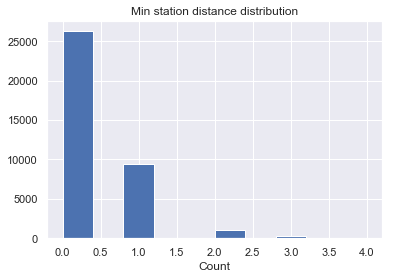

In [1373]:
plt.hist(all_candidates['station_cnt'], bins=10)
plt.xlabel('Min station distance')
plt.xlabel('Count')
plt.title('Min station distance distribution')
plt.show()

### 1.3.3 Расстояние до ближайшей станции метро

In [1374]:
all_candidates['station_dist'] = station_dist

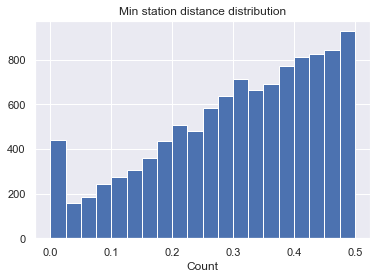

In [1375]:
plt.hist(all_candidates['station_dist'][all_candidates['station_dist'] < 5], bins=20)
plt.xlabel('Min station distance')
plt.xlabel('Count')
plt.title('Min station distance distribution')
plt.show()

### 1.3.4 Пассажиропоток ближайших станций

In [1376]:
metro_passenger_flow_raw['title'] = 'Станция ' + metro_passenger_flow_raw['NameOfStation']\
    .replace('Савеловская', 'Савёловская')

In [1377]:
link = metro_passenger_flow_raw.groupby('title')['IncomingPassengers'].mean()

In [1378]:
pass_flow = []
bad_stations = set()
for stations in tqdm(station_set, total=len(station_set)):
    curr_pass_flow = 0
    for st in stations:
        try:
            curr_pass_flow += link.loc[st]
        except KeyError:
            bad_stations.add(st)
    curr_pass_flow = curr_pass_flow/len(stations) if len(stations) > 0 else 0
    pass_flow.append(curr_pass_flow)

100%|██████████| 37131/37131 [00:00<00:00, 208292.31it/s]


In [1379]:
all_candidates['passenger_flow'] = (pass_flow - np.mean(pass_flow)) / np.std(pass_flow)

In [1380]:
all_candidates['passenger_flow']

0       -0.512940
1        1.180246
2        0.665045
4       -0.512940
5       -0.512940
           ...   
32513   -0.512940
32574   -0.512940
32576    1.183904
32593   -0.512940
32729   -0.512940
Name: passenger_flow, Length: 37131, dtype: float64

### 1.3.5 Расстояние до центра Москвы

In [1381]:
dist_to_center = []
moscow_center = (55.751535, 37.619120)
for _, row in tqdm(all_candidates.iterrows(), total=all_candidates.shape[0]):
    dist_to_center.append(calculate_distance((row['lat'], row['lon']), moscow_center))
all_candidates['dist_to_center'] = dist_to_center

100%|██████████| 37131/37131 [00:03<00:00, 10628.86it/s]


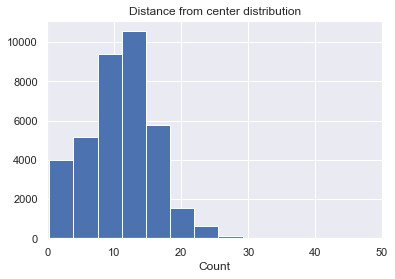

In [1382]:
plt.hist(all_candidates['dist_to_center'], bins=200)
plt.xlabel('Dist from center')
plt.xlabel('Count')
plt.title('Distance from center distribution')
plt.xlim(0, 50)
plt.show()

In [1383]:
all_candidates = all_candidates[all_candidates['dist_to_center'] < 40]

### 1.3.6 Дома в ближайшей окрестности

In [1384]:
house_reester_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32923 entries, 0 to 32729
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        32923 non-null  object 
 1   square, m2     32923 non-null  object 
 2   year           32923 non-null  object 
 3   floor_cnt      32923 non-null  object 
 4   entrance_cnt   3917 non-null   object 
 5   apartment_cnt  32923 non-null  float64
 6   lat            32923 non-null  float64
 7   lon            32923 non-null  float64
 8   area           32923 non-null  object 
 9   district       32923 non-null  object 
 10  population     32923 non-null  float64
 11  type           32923 non-null  object 
 12  description    32923 non-null  object 
dtypes: float64(4), object(9)
memory usage: 4.8+ MB


Для каждой точки датасета считаем сет ближайших к ней домов.

In [1385]:
def calculate_distance(ptA, ptB):
    """
    ptA: (lat, lon) of the first point
    ptB: (lat, lon) of the second point
    """
    lat_diff = ptA[0] - ptB[0]
    lon_diff = ptA[1] - ptB[1]
    lat_dist = lat_diff * 111.37
    lon_dist = lon_diff * np.cos(ptA[0] * np.pi / 180) * 111.37
    return np.sqrt(lon_dist ** 2 + lat_dist ** 2)

In [1404]:
all_candidates.head(2)

,title,description,type,lat,lon,area,district,address,"square, m2",year,floor_cnt,entrance_cnt,apartment_cnt,population,pvz_cnt,station_cnt,station_dist,passenger_flow,dist_to_center,coverage
0,"ГБУК г. Москвы «ОКЦ ЮАО», Библиотека №140",Библиотека,library,55.583967,37.685992,Южный административный округ,Бирюлёво Восточное,"Российская Федерация, город Москва, внутригоро...",,,,,,,1,0,5.000000,-0.512940,19.130877,14856.0
1,"ГБУК г. Москвы «ОКЦ ЮАО», Библиотека №166 им. ...",Библиотека,library,55.708619,37.586619,Южный административный округ,Донской,"Российская Федерация, город Москва, внутригоро...",,,,,,,3,2,0.059873,1.180246,5.196476,7980.0


In [1405]:
house_reester_.head(2)

,address,"square, m2",year,floor_cnt,entrance_cnt,apartment_cnt,lat,lon,area,district,population,type,description
0,"пр-кт. Мира, д. 188 Б, к. 1, Москва",54804.10,2014,58,1,370.0,55.834472,37.658050,Северо-Восточный административный округ,Ростокино,1110.0,house,Многоквартирный жилой дом
1,"пр-кт. Мира, д. 188Б, к. 3, Москва",53253.20,2015,58,1,356.0,55.835483,37.658338,Северо-Восточный административный округ,Ростокино,1068.0,house,Многоквартирный жилой дом


In [1389]:
house_reester_['lat'] = house_reester_['lat'].astype(float)
house_reester_['lon'] = house_reester_['lon'].astype(float)

In [1390]:
house_reester_['population'] = house_reester_['population'].astype(float)

In [1391]:
def calculate_distance_for_point(point, houses):
    lats = np.array(houses["lat"])
    lons = np.array(houses["lon"])
    lat_dist = (lats - point['lat']) * 111.37
    lon_dist = (lons - point['lon']) * np.cos(point['lat'] * np.pi / 180) * 111.37
    return np.sqrt(lon_dist ** 2 + lat_dist ** 2)

In [1392]:
neighbors_for_point = []
for _, point in tqdm(all_candidates.iterrows(), total=all_candidates.shape[0]):
    distances = calculate_distance_for_point(point, house_reester_)
    neighbors_for_point.append(set(house_reester_.index[distances < RADIUS]))


100%|██████████| 37124/37124 [00:18<00:00, 2058.90it/s]


In [1393]:
neighbors_for_point[:1]

[{455,
  456,
  809,
  1819,
  1820,
  1900,
  3969,
  3986,
  3987,
  3989,
  3990,
  5435,
  10412,
  10939,
  10940,
  10974,
  10977,
  10979}]

In [1394]:
populations = []
for i, _ in tqdm(all_candidates.iterrows(), total=all_candidates.shape[0]):
    populations.append(house_reester_.loc[list(neighbors_for_point[i])]['population'].sum())

100%|██████████| 37124/37124 [00:22<00:00, 1681.87it/s]


In [1398]:
all_candidates['coverage'] = populations

In [1400]:
all_candidates.head()

,title,description,type,lat,lon,area,district,address,"square, m2",year,floor_cnt,entrance_cnt,apartment_cnt,population,pvz_cnt,station_cnt,station_dist,passenger_flow,dist_to_center,coverage
0,"ГБУК г. Москвы «ОКЦ ЮАО», Библиотека №140",Библиотека,library,55.583967,37.685992,Южный административный округ,Бирюлёво Восточное,"Российская Федерация, город Москва, внутригоро...",,,,,,,1,0,5.000000,-0.512940,19.130877,14856.0
1,"ГБУК г. Москвы «ОКЦ ЮАО», Библиотека №166 им. ...",Библиотека,library,55.708619,37.586619,Южный административный округ,Донской,"Российская Федерация, город Москва, внутригоро...",,,,,,,3,2,0.059873,1.180246,5.196476,7980.0
2,"ГБУК г. Москвы «ОКЦ ЮЗАО», Библиотека №169 «Пр...",Библиотека,library,55.646156,37.477928,Юго-Западный административный округ,Тёплый Стан,"город Москва, Ленинский проспект, дом 127",,,,,,,2,1,0.226232,0.665045,14.712966,13377.0
4,"ГБУК г. Москвы «ОКЦ ЮВАО», Библиотека №115",Библиотека,library,55.708541,37.782957,Юго-Восточный административный округ,Кузьминки,"Российская Федерация, город Москва, внутригоро...",,,,,,,1,0,5.000000,-0.512940,11.340570,18969.0
5,"ГБУК г. Москвы «ОКЦ ЮАО», Детская библиотека №153",Библиотека,library,55.621616,37.753725,Южный административный округ,Зябликово,"Российская Федерация, город Москва, внутригоро...",,,,,,,3,0,5.000000,-0.512940,16.763201,20394.0


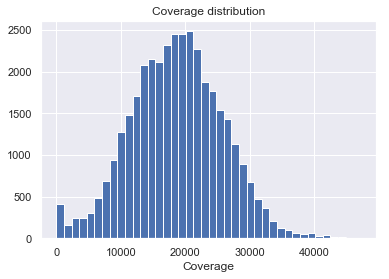

In [1403]:
plt.hist(all_candidates['coverage'], bins=40)
plt.xlabel('Coverage')
plt.title('Coverage distribution')
plt.show()

Так, мы спроектировали достаточно разносторонние метрики, отражающие внешние факторы, которые могут влиять на удобство той или иной локации для расположения постамата.